# Training Data Analysis

天然物と合成化合物の学習データにおける分子特性の分布を比較します。

In [2]:
from pathlib import Path
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from tqdm import tqdm

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.9)

In [3]:
# Load data
DATA_DIR = Path("../data")
NAT_TRAIN = DATA_DIR / "natural_train.smi"
SYN_TRAIN = DATA_DIR / "synthetic_train.smi"

assert NAT_TRAIN.exists(), f"Missing: {NAT_TRAIN}"
assert SYN_TRAIN.exists(), f"Missing: {SYN_TRAIN}"


def read_smiles(path: Path, sample_size: int | None = None) -> list[str]:
    """Read SMILES from file, optionally sampling."""
    smiles_list = []
    with path.open() as f:
        for line in f:
            s = line.strip().split()[0]
            if s:
                smiles_list.append(s)
    
    if sample_size is not None and len(smiles_list) > sample_size:
        random.seed(42)
        smiles_list = random.sample(smiles_list, sample_size)
    
    return smiles_list


# サンプリングして読み込み（全データは大きすぎるため）
SAMPLE_SIZE = 50000
nat_smiles = read_smiles(NAT_TRAIN, SAMPLE_SIZE)
syn_smiles = read_smiles(SYN_TRAIN, SAMPLE_SIZE)

print(f"Natural compounds: {len(nat_smiles):,}")
print(f"Synthetic compounds: {len(syn_smiles):,}")

Natural compounds: 50,000
Synthetic compounds: 50,000


In [4]:
# Calculate molecular properties
def calc_properties(smiles: str) -> dict | None:
    """Calculate molecular descriptors from SMILES."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    try:
        return {
            "MW": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "HBA": Lipinski.NumHAcceptors(mol),
            "HBD": Lipinski.NumHDonors(mol),
            "TPSA": Descriptors.TPSA(mol),
            "RotBonds": Lipinski.NumRotatableBonds(mol),
            "Rings": Lipinski.RingCount(mol),
            "AromaticRings": Lipinski.NumAromaticRings(mol),
        }
    except Exception:
        return None


# Calculate for natural compounds
nat_props = []
for smi in tqdm(nat_smiles, desc="Calculating natural properties"):
    props = calc_properties(smi)
    if props is not None:
        props["label"] = "natural"
        nat_props.append(props)

# Calculate for synthetic compounds
syn_props = []
for smi in tqdm(syn_smiles, desc="Calculating synthetic properties"):
    props = calc_properties(smi)
    if props is not None:
        props["label"] = "synthetic"
        syn_props.append(props)

# Combine into DataFrame
df = pd.DataFrame(nat_props + syn_props)
print(f"\nTotal valid compounds: {len(df):,}")
print(f"Natural: {len(nat_props):,}, Synthetic: {len(syn_props):,}")
df.head()

Calculating natural properties:   1%|          | 305/50000 [00:00<00:31, 1567.53it/s]

Calculating synthetic properties: 100%|██████████| 50000/50000 [00:19<00:00, 2626.54it/s]



Total valid compounds: 100,000
Natural: 50,000, Synthetic: 50,000


,MW,LogP,HBA,HBD,TPSA,RotBonds,Rings,AromaticRings,label
0,509.352,5.9868,6,0,74.97,7,4,4,natural
1,524.563,0.6594,11,6,167.53,12,3,2,natural
2,477.043,3.7668,3,1,60.85,4,1,0,natural
3,400.475,2.7128,5,1,87.69,4,4,1,natural
4,961.551,19.5417,6,0,78.90,52,0,0,natural


In [5]:
# Summary statistics
df.groupby("label").describe()["LogP"].T

label,natural,synthetic
count,50000.000000,50000.000000
mean,4.111812,1.658919
std,4.936519,1.158379
min,-38.037800,-3.982300
25%,1.586050,0.890300
50%,3.318110,1.729850
75%,5.146600,2.523935
max,37.833800,4.493600


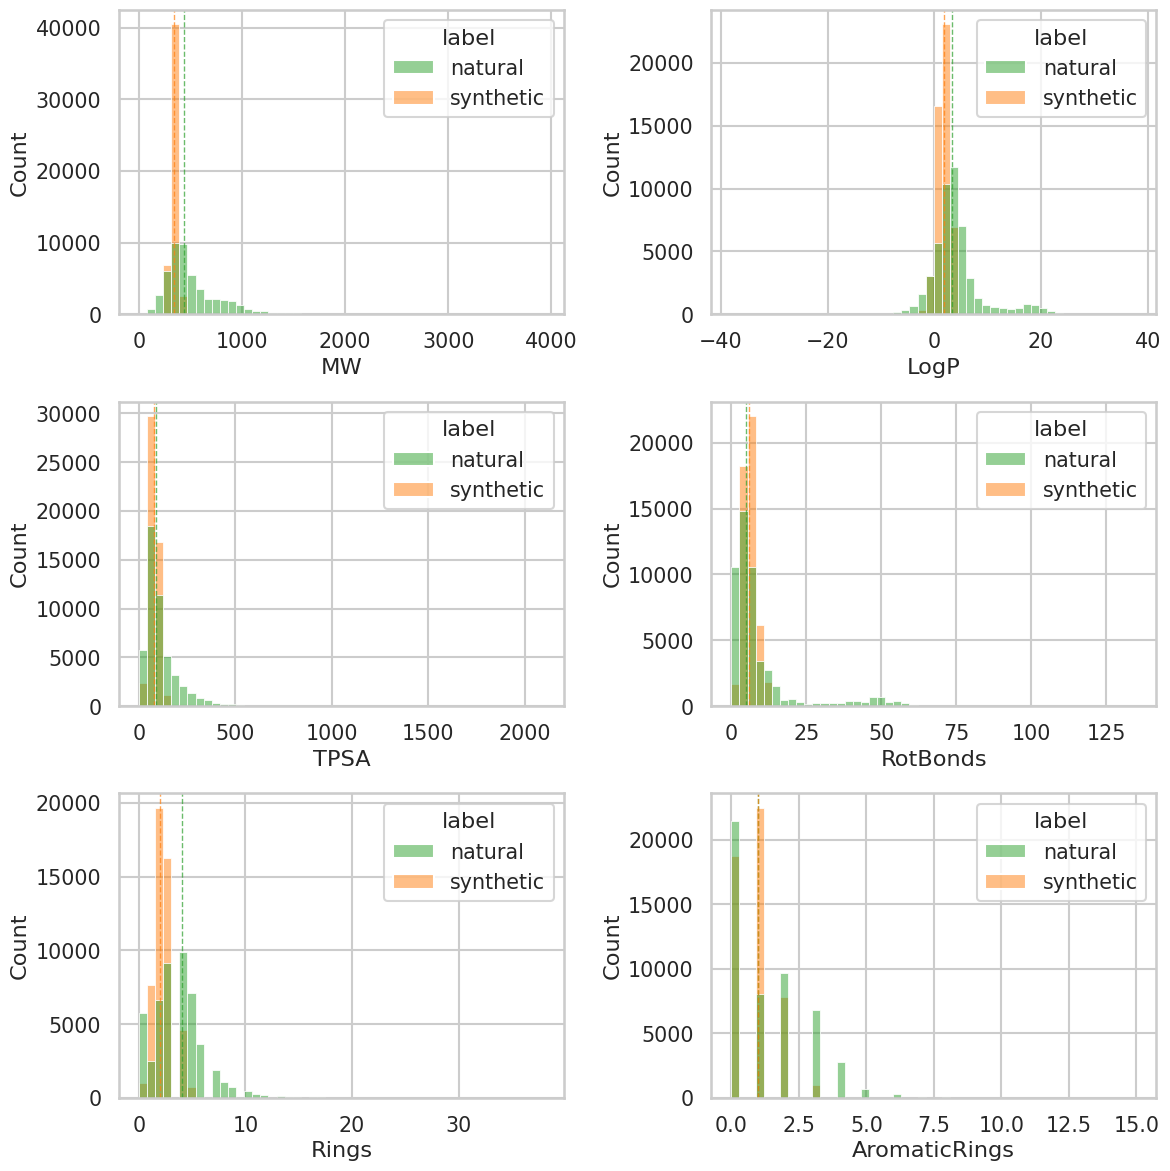

In [6]:
# Distribution plots for key properties
properties = ["MW", "LogP", "TPSA", "RotBonds", "Rings", "AromaticRings"]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, prop in enumerate(properties):
    ax = axes[idx]
    
    # Histogram
    sns.histplot(
        data=df,
        x=prop,
        hue="label",
        common_norm=False,
        alpha=0.5,
        ax=ax,
        palette={"natural": "tab:green", "synthetic": "tab:orange"},
        bins=50,
    )
    
    ax.set_xlabel(prop)
    ax.set_ylabel("Count")
    
    # Add median lines
    nat_median = df[df["label"] == "natural"][prop].median()
    syn_median = df[df["label"] == "synthetic"][prop].median()
    ax.axvline(nat_median, color="tab:green", linestyle="--", linewidth=1, alpha=0.7)
    ax.axvline(syn_median, color="tab:orange", linestyle="--", linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()

/tmp/55218.1.interactive/ipykernel_1676471/1811236249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/55218.1.interactive/ipykernel_1676471/1811236249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/55218.1.interactive/ipykernel_1676471/1811236249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/55218.1.interactive/ipykernel_1676471/1811236249.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for t

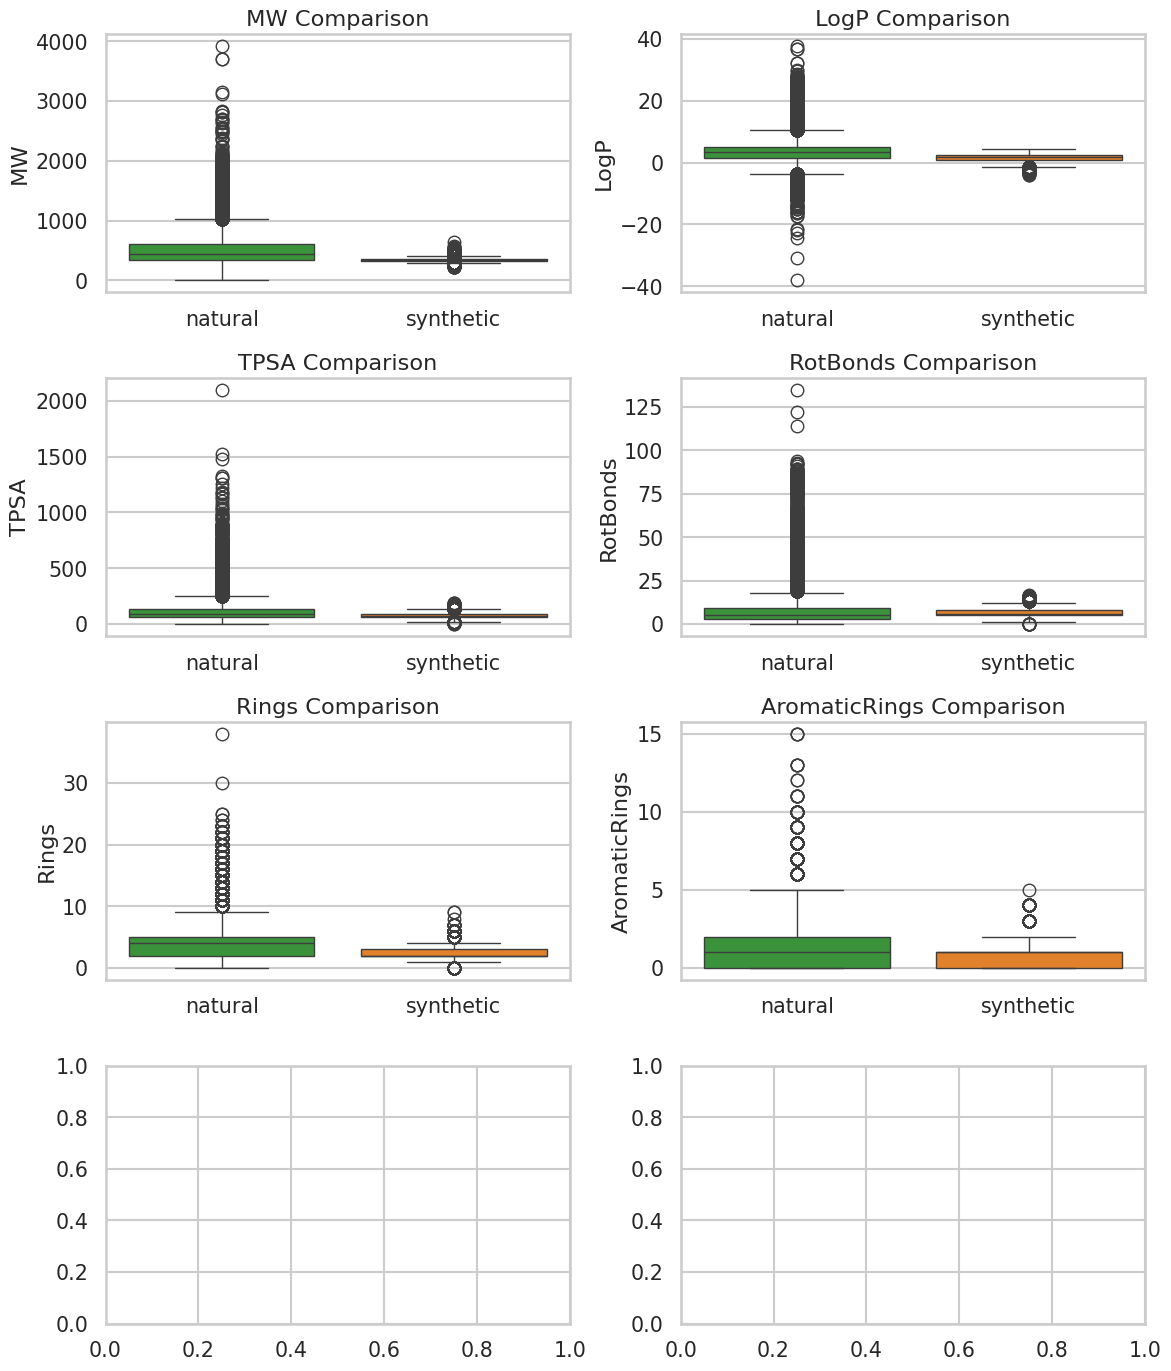

In [7]:
# Box plots for comparison
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
axes = axes.flatten()

for idx, prop in enumerate(properties):
    ax = axes[idx]
    
    sns.boxplot(
        data=df,
        x="label",
        y=prop,
        ax=ax,
        palette={"natural": "tab:green", "synthetic": "tab:orange"},
    )
    
    ax.set_xlabel("")
    ax.set_ylabel(prop)
    ax.set_title(f"{prop} Comparison")

plt.tight_layout()
plt.show()

In [8]:
# Statistical comparison using Kolmogorov-Smirnov test
from scipy.stats import ks_2samp

print("Kolmogorov-Smirnov test results:")
print("="*60)

for prop in properties:
    nat_data = df[df["label"] == "natural"][prop].values
    syn_data = df[df["label"] == "synthetic"][prop].values
    
    statistic, pvalue = ks_2samp(nat_data, syn_data)
    
    nat_median = df[df["label"] == "natural"][prop].median()
    syn_median = df[df["label"] == "synthetic"][prop].median()
    
    print(f"{prop}:")
    print(f"  KS statistic: {statistic:.4f}")
    print(f"  p-value: {pvalue:.4e}")
    print(f"  Natural median: {nat_median:.2f}")
    print(f"  Synthetic median: {syn_median:.2f}")
    print()

Kolmogorov-Smirnov test results:
MW:
  KS statistic: 0.5688
  p-value: 0.0000e+00
  Natural median: 437.54
  Synthetic median: 346.42

LogP:
  KS statistic: 0.4403
  p-value: 0.0000e+00
  Natural median: 3.32
  Synthetic median: 1.73

TPSA:
  KS statistic: 0.2772
  p-value: 0.0000e+00
  Natural median: 86.74
  Synthetic median: 75.71

RotBonds:
  KS statistic: 0.1965
  p-value: 0.0000e+00
  Natural median: 5.00
  Synthetic median: 6.00

Rings:
  KS statistic: 0.4105
  p-value: 0.0000e+00
  Natural median: 4.00
  Synthetic median: 2.00

AromaticRings:
  KS statistic: 0.2335
  p-value: 0.0000e+00
  Natural median: 1.00
  Synthetic median: 1.00



In [9]:
# Compute Ertl NP score for all natural compounds
from pathlib import Path
import pickle
import urllib.request
import importlib.util
import gzip
import shutil

# Ensure npscorer.py and publicnp.model are available
npscorer_py = Path("npscorer.py")
public_model = Path("publicnp.model")
if not npscorer_py.exists():
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/NP_Score/npscorer.py",
        str(npscorer_py),
    )
if not public_model.exists():
    gz_path = Path("publicnp.model.gz")
    if not gz_path.exists():
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/NP_Score/publicnp.model.gz",
            str(gz_path),
        )
    # decompress
    with gzip.open(gz_path, "rb") as f_in, open(public_model, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

# Dynamic import of npscorer with guards
spec = importlib.util.spec_from_file_location("npscorer", str(npscorer_py))
if spec is None or spec.loader is None:
    raise ImportError("Failed to load npscorer module spec")
npscorer = importlib.util.module_from_spec(spec)
spec.loader.exec_module(npscorer)

with open(public_model, "rb") as f:
    fs = pickle.load(f)


def ertl_np_score(smiles: str) -> float | None:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return float(npscorer.scoreMol(mol, fs))
    except Exception:
        return None


# Load all natural compounds
NAT_ALL = DATA_DIR / "natural_all.smi"
assert NAT_ALL.exists(), f"Missing: {NAT_ALL}"

nat_all_smiles = read_smiles(NAT_ALL, sample_size=None)  # No sampling - load all
print(f"Total natural compounds: {len(nat_all_smiles):,}")

# Compute NP scores
nat_all_np_scores = []
for smi in tqdm(nat_all_smiles, desc="Calculating NP scores"):
    score = ertl_np_score(smi)
    if score is not None:
        nat_all_np_scores.append(score)

print(f"Valid NP scores computed: {len(nat_all_np_scores):,}")

Total natural compounds: 694,709


Calculating NP scores:  40%|███▉      | 275289/694709 [01:17<02:01, 3438.39it/s][21:25:32] Explicit valence for atom # 1 P, 6, is greater than permitted
[21:25:32] Unusual charge on atom 0 number of radical electrons set to zero
Calculating NP scores:  55%|█████▌    | 385181/694709 [01:48<01:38, 3155.60it/s][21:26:03] WARNING: not removing hydrogen atom without neighbors
[21:26:03] WARNING: not removing hydrogen atom without neighbors
Calculating NP scores:  86%|████████▌ | 598613/694709 [02:51<00:27, 3547.64it/s][21:27:05] Unusual charge on atom 0 number of radical electrons set to zero
[21:27:05] Unusual charge on atom 24 number of radical electrons set to zero
[21:27:05] Unusual charge on atom 14 number of radical electrons set to zero
Calculating NP scores:  86%|████████▌ | 599025/694709 [02:51<00:25, 3715.70it/s][21:27:05] Unusual charge on atom 22 number of radical electrons set to zero
[21:27:05] Unusual charge on atom 23 number of radical electrons set to zero
[21:27:05] Unusua

Valid NP scores computed: 694,705


NP Score Statistics for All Natural Compounds:
Count: 694,705
Mean: 1.122
Median: 1.209
Std: 1.371
Min: -3.533
Max: 4.117
25th percentile: 0.062
75th percentile: 2.236


/tmp/55218.1.interactive/ipykernel_1676471/2977789676.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


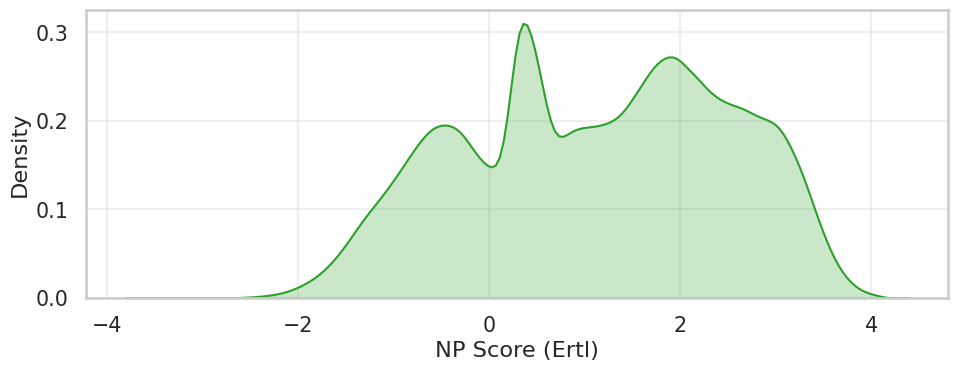

In [10]:
# KDE plot of NP scores for all natural compounds
import numpy as np

# Create DataFrame for plotting
np_score_df = pd.DataFrame({"NP_score": nat_all_np_scores})

# Summary statistics
print("NP Score Statistics for All Natural Compounds:")
print("=" * 60)
print(f"Count: {len(nat_all_np_scores):,}")
print(f"Mean: {np.mean(nat_all_np_scores):.3f}")
print(f"Median: {np.median(nat_all_np_scores):.3f}")
print(f"Std: {np.std(nat_all_np_scores):.3f}")
print(f"Min: {np.min(nat_all_np_scores):.3f}")
print(f"Max: {np.max(nat_all_np_scores):.3f}")
print(f"25th percentile: {np.percentile(nat_all_np_scores, 25):.3f}")
print(f"75th percentile: {np.percentile(nat_all_np_scores, 75):.3f}")

# Create KDE plot
fig, ax = plt.subplots(figsize=(10, 4))

sns.kdeplot(
    data=np_score_df,
    x="NP_score",
    color="tab:green",
    fill=True,
    # alpha=0.6,
    ax=ax,
)

ax.set_xlabel("NP Score (Ertl)")
ax.set_ylabel("Density")
# ax.set_title("Distribution of NP Scores for All Natural Compounds")
ax.legend(frameon=False)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()